In [16]:
import polars as pl
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets

In [17]:
lf = pl.scan_csv("data/GlobalWeatherRepository.csv")
dropped_columns = [
                   "country", # country can be derived from location_name
                   "timezone", # timezone can be derived from location_name
                   "last_updated", # last_updated can be derived from last_updated_epoch
                   "temperature_fahrenheit", # temperature_fahrenheit can be derived from temperature_celsius
                   "condition_text", # condition_text could be used for a classification problem, but we're shooting for 
                   "wind_mph", # wind_mph can be derived from wind_kph
                   "wind_direction", # wind_direction can be derived from wind_degree
                   "pressure_in", # pressure_in can be derived from pressure_mb
                   "precip_in",  # precip_in can be derived from precip_mm
                   "feels_like_fahrenheit", # feels_like_fahrenheit can be derived from feels_like_celsius. Study will be done on correlations to find if feels_like_celsius is too correlated with temperature_celsius
                   "visibility_miles", # visibility_miles can be derived from visibility_km
                   "gust_mph", # gust_mph can be derived from gust_kph
                  ]

In [18]:
lf = lf.drop(dropped_columns)
lf.collect()

location_name,latitude,longitude,last_updated_epoch,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
str,f64,f64,i64,f64,f64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,str,str,str,str,i64
"""Kabul""",34.52,69.18,1715849100,26.6,13.3,338,1012.0,0.0,24,30,25.3,10.0,7.0,15.3,277.0,103.0,1.1,0.2,8.4,26.6,1,1,"""04:50 AM""","""06:50 PM""","""12:12 PM""","""01:11 AM""","""Waxing Gibbous""",55
"""Tirana""",41.33,19.82,1715849100,19.0,11.2,320,1012.0,0.1,94,75,19.0,10.0,5.0,18.4,193.6,97.3,0.9,0.1,1.1,2.0,1,1,"""05:21 AM""","""07:54 PM""","""12:58 PM""","""02:14 AM""","""Waxing Gibbous""",55
"""Algiers""",36.76,3.05,1715849100,23.0,15.1,280,1011.0,0.0,29,0,24.6,10.0,5.0,22.3,540.7,12.2,65.1,13.4,10.4,18.4,1,1,"""05:40 AM""","""07:50 PM""","""01:15 PM""","""02:14 AM""","""Waxing Gibbous""",55
"""Andorra La Vella""",42.5,1.52,1715849100,6.3,11.9,215,1007.0,0.3,61,100,3.8,2.0,2.0,13.7,170.2,64.4,1.6,0.2,0.7,0.9,1,1,"""06:31 AM""","""09:11 PM""","""02:12 PM""","""03:31 AM""","""Waxing Gibbous""",55
"""Luanda""",-8.84,13.23,1715849100,26.0,13.0,150,1011.0,0.0,89,50,28.7,10.0,8.0,20.2,2964.0,19.0,72.7,31.5,183.4,262.3,5,10,"""06:12 AM""","""05:55 PM""","""01:17 PM""","""12:38 AM""","""Waxing Gibbous""",55
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Caracas""",10.5,-66.9167,1751359500,25.0,7.2,157,1015.0,0.0,79,0,28.2,2.0,0.0,14.4,851.0,44.0,9.25,2.035,11.1,21.645,1,1,"""06:10 AM""","""06:53 PM""","""11:37 AM""","""11:54 PM""","""Waxing Crescent""",34
"""Hanoi""",21.0333,105.85,1751359500,29.2,10.1,108,1003.0,0.73,79,75,33.5,10.0,3.2,13.6,751.1,57.0,44.215,36.26,43.475,46.435,3,5,"""05:19 AM""","""06:42 PM""","""10:41 AM""","""11:06 PM""","""Waxing Crescent""",30
"""Sanaa""",15.3547,44.2067,1751359500,26.5,9.4,49,1011.0,0.0,16,47,24.9,10.0,11.5,10.8,266.4,90.0,2.96,4.81,27.75,149.11,2,3,"""05:37 AM""","""06:38 PM""","""10:57 AM""","""11:19 PM""","""Waxing Crescent""",31


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


<Axes: >

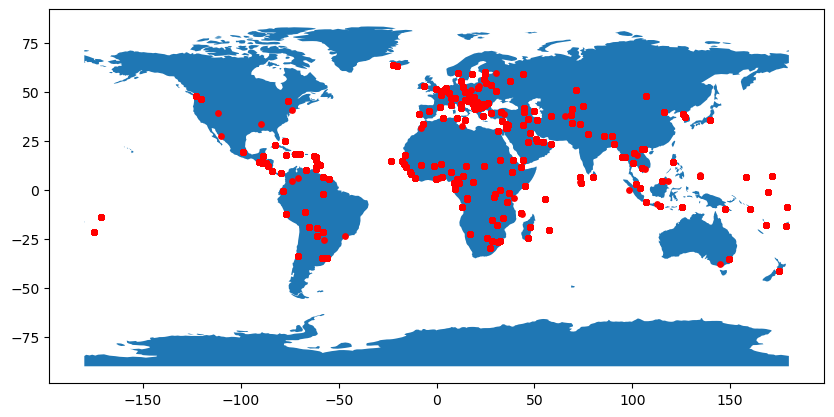

In [23]:
lon_lat = lf.select(["latitude", "longitude"])
geometry = [Point(xy) for xy in zip(lon_lat.select("longitude").collect().to_series(), lon_lat.select("latitude").collect().to_series())]
gdf = GeoDataFrame(lon_lat.collect(), geometry=geometry)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)